In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras import regularizers
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import time

###############################

#Checking Gpu
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

###############################


# Prepare the training dataset.
batch_size = 128
scaler = StandardScaler()

Default GPU Device:/device:GPU:0


Neural networks vs SVMs on sparse functions

In [ ]:
#for every input dimension, we iterate this process 5 times: create training set of size 2000 with label y=x_1*x_2, train a NN, train a SVM, store the R^2 scores
#and then compute mean and std dev over the 5 ieterations
dimensions=np.linspace(20,65,10, dtype=int)
iters=5
r2_nn_mean=[]
r2_nn_std=[]
r2_svm_mean=[]
r2_svm_std=[]
#dataset creation
for d in dimensions:
  r2_nn=[]
  r2_svm=[]
  for iter in range(iters):
    x_train = np.random.normal(size=(2000,d))
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    y = []
    for i in range(x_train.shape[0]):
      y.append(x_train[i][1]*x_train[i][2])
    y_train = np.array(y)

    x_test = np.random.normal(size=(1000,d))
    scaler.fit(x_test)
    x_test=scaler.transform(x_test)
    y = []
    for i in range(x_test.shape[0]):
      y.append(x_test[i][1]*x_test[i][2])
    y_test = np.array(y)

    #depth=2, width=500 NN
    keras.backend.clear_session()
    train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    inputs = keras.Input(shape=(d,), name="digits")
    layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
    layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
    outputs = Dense(1)(layer2)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile( metrics = ["mean_squared_error"] )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.SGD(0.01)
    train_acc_metric = keras.metrics.MeanSquaredError()
    train_loss_metric = keras.losses.MeanSquaredError()

    # Defining train step and test step
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, logits)
        return loss_value

    @tf.function
    def test_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)


    # Training cycle
    epochs = 150
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train)

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        #if epoch==149:
          #tr_acc.append(train_acc.numpy())
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        print("Time taken: %.2fs" % (time.time() - start_time))

    model.evaluate(x_test,y_test)
    r2_nn.append(sklearn.metrics.r2_score(y_test, model(x_test)))

    regr = svm.SVR(kernel='rbf', epsilon='')
    regr.fit(x_train, y_train)
    r2_svm.append(sklearn.metrics.r2_score(y_test, regr.predict(x_test)))

  r2_nn_mean.append(np.mean(np.array(r2_nn)))
  r2_nn_std.append(np.std(np.array(r2_nn)))
  r2_svm_mean.append(np.mean(np.array(r2_svm)))
  r2_svm_std.append(np.std(np.array(r2_svm)))

Output streaming troncato alle ultime 5000 righe.

Start of epoch 152
Training acc over epoch: 0.0016
Time taken: 0.03s

Start of epoch 153
Training acc over epoch: 0.0016
Time taken: 0.03s

Start of epoch 154
Training acc over epoch: 0.0016
Time taken: 0.04s

Start of epoch 155
Training acc over epoch: 0.0015
Time taken: 0.03s

Start of epoch 156
Training acc over epoch: 0.0015
Time taken: 0.04s

Start of epoch 157
Training acc over epoch: 0.0014
Time taken: 0.03s

Start of epoch 158
Training acc over epoch: 0.0014
Time taken: 0.03s

Start of epoch 159
Training acc over epoch: 0.0013
Time taken: 0.03s

Start of epoch 160
Training acc over epoch: 0.0013
Time taken: 0.03s

Start of epoch 161
Training acc over epoch: 0.0013
Time taken: 0.03s

Start of epoch 162
Training acc over epoch: 0.0013
Time taken: 0.03s

Start of epoch 163
Training acc over epoch: 0.0012
Time taken: 0.04s

Start of epoch 164
Training acc over epoch: 0.0012
Time taken: 0.03s

Start of epoch 165
Training acc over ep

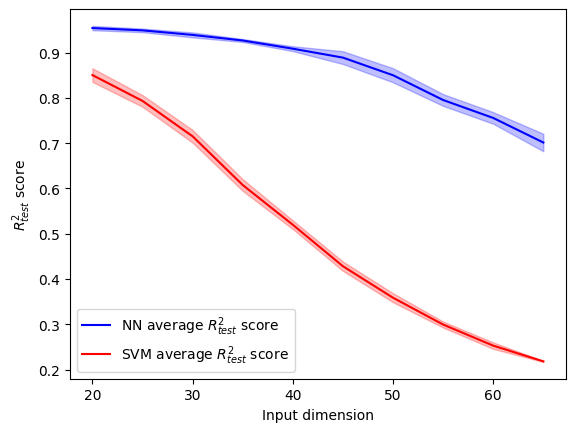

In [ ]:
#plotting the results of the previous cell, R^2 score for both NN and SVM
plt.plot(dimensions, r2_nn_mean, color='b', label="NN average $R^2_{test}$ score")
plt.fill_between(dimensions, np.array(r2_nn_mean)+np.array(r2_nn_std), np.array(r2_nn_mean)-np.array(r2_nn_std), color='b', alpha=0.25)
plt.plot(dimensions, r2_svm_mean, color='r', label="SVM average $R^2_{test}$ score")
plt.fill_between(dimensions, np.array(r2_svm_mean)+np.array(r2_svm_std), np.array(r2_svm_mean)-np.array(r2_svm_std), color='r', alpha=0.25)
plt.xlabel("Input dimension")
plt.ylabel("$R^2_{test}$ score")
plt.legend()
plt.show()

In [ ]:
#same process as in the previous cells, but with target y=x_1*x_2*x_3
dimensions=np.linspace(20,65,10, dtype=int)
iters=5
r2_nn_mean=[]
r2_nn_std=[]
r2_svm_mean=[]
r2_svm_std=[]
#dataset creation
for d in dimensions:
  r2_nn=[]
  r2_svm=[]
  for iter in range(iters):
    x_train = np.random.normal(size=(2000,d))
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    y = []
    for i in range(x_train.shape[0]):
      y.append(x_train[i][1]*x_train[i][2]*x_train[i][3])
    y_train = np.array(y)

    x_test = np.random.normal(size=(1000,d))
    scaler.fit(x_test)
    x_test=scaler.transform(x_test)
    y = []
    for i in range(x_test.shape[0]):
      y.append(x_test[i][1]*x_test[i][2]*x_test[i][3])
    y_test = np.array(y)

    #depth=2, width=500 NN
    keras.backend.clear_session()
    train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    inputs = keras.Input(shape=(d,), name="digits")
    layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
    layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
    outputs = Dense(1)(layer2)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile( metrics = ["mean_squared_error"] )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.SGD(0.01)
    train_acc_metric = keras.metrics.MeanSquaredError()
    train_loss_metric = keras.losses.MeanSquaredError()

    # Defining train step and test step
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_acc_metric.update_state(y, logits)
        return loss_value

    @tf.function
    def test_step(x, y):
        val_logits = model(x, training=False)
        val_acc_metric.update_state(y, val_logits)


    # Training cycle
    epochs = 150
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train)

        # Display metrics at the end of each epoch.
        train_acc = train_acc_metric.result()
        #if epoch==149:
          #tr_acc.append(train_acc.numpy())
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()

        print("Time taken: %.2fs" % (time.time() - start_time))

    model.evaluate(x_test,y_test)
    r2_nn.append(sklearn.metrics.r2_score(y_test, model(x_test)))

    regr = svm.SVR(kernel='rbf')
    regr.fit(x_train, y_train)
    r2_svm.append(sklearn.metrics.r2_score(y_test, regr.predict(x_test)))

  r2_nn_mean.append(np.mean(np.array(r2_nn)))
  r2_nn_std.append(np.std(np.array(r2_nn)))
  r2_svm_mean.append(np.mean(np.array(r2_svm)))
  r2_svm_std.append(np.std(np.array(r2_svm)))

Output streaming troncato alle ultime 5000 righe.

Start of epoch 152
Training acc over epoch: 0.0035
Time taken: 0.03s

Start of epoch 153
Training acc over epoch: 0.0034
Time taken: 0.03s

Start of epoch 154
Training acc over epoch: 0.0034
Time taken: 0.06s

Start of epoch 155
Training acc over epoch: 0.0040
Time taken: 0.03s

Start of epoch 156
Training acc over epoch: 0.0028
Time taken: 0.03s

Start of epoch 157
Training acc over epoch: 0.0029
Time taken: 0.03s

Start of epoch 158
Training acc over epoch: 0.0034
Time taken: 0.06s

Start of epoch 159
Training acc over epoch: 0.0025
Time taken: 0.03s

Start of epoch 160
Training acc over epoch: 0.0027
Time taken: 0.04s

Start of epoch 161
Training acc over epoch: 0.0023
Time taken: 0.03s

Start of epoch 162
Training acc over epoch: 0.0023
Time taken: 0.03s

Start of epoch 163
Training acc over epoch: 0.0021
Time taken: 0.03s

Start of epoch 164
Training acc over epoch: 0.0023
Time taken: 0.03s

Start of epoch 165
Training acc over ep

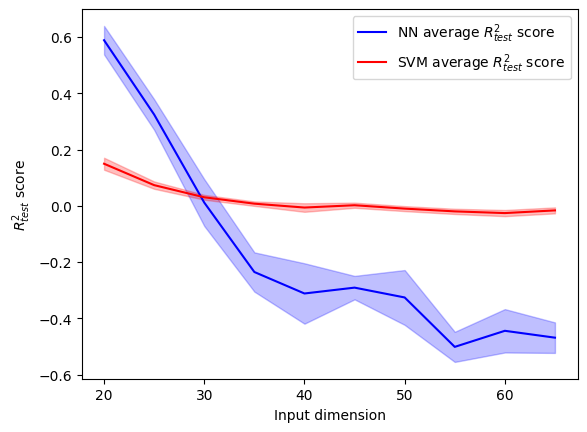

In [ ]:
#plotting the results of the previous cell, R^2 for NN and SVM
plt.plot(dimensions, r2_nn_mean, color='b', label="NN average $R^2_{test}$ score")
plt.fill_between(dimensions, np.array(r2_nn_mean)+np.array(r2_nn_std), np.array(r2_nn_mean)-np.array(r2_nn_std), color='b', alpha=0.25)
plt.plot(dimensions, r2_svm_mean, color='r', label="SVM average $R^2_{test}$ score")
plt.fill_between(dimensions, np.array(r2_svm_mean)+np.array(r2_svm_std), np.array(r2_svm_mean)-np.array(r2_svm_std), color='r', alpha=0.25)
plt.xlabel("Input dimension")
plt.ylabel("$R^2_{test}$ score")
plt.legend()
plt.show()

Verifying that sparse MSP functions are easier to learn for a 2HL neural network, requiring lower sample sizes to obtain the same performance, as a function of "d", the dimension of the input vector.
In this instance, we use f=x_1+x_1*x_2 as an example, in order to keep the dimension of the true signal k<<d. We request a R2 score of 0.90 or better to say that the function has been learned.

In [ ]:
#learning h*=x_1*x_2+x_1 (MSP)
dimensions=np.linspace(20,65,10, dtype=int)
iters=5
sample_size_mean=[]
sample_size_std=[]
#dataset creation
for d in dimensions:
  N=[]
  for iter in range(iters):
    r2_test=0.91  #initializing r2 score
    n=(d-5)*d     #intializing sample size
    while r2_test >= 0.90:
      n=n-2*d     #explore sample sizes with step 2d
      x_train = np.random.normal(size=(n,d))
      scaler.fit(x_train)
      x_train=scaler.transform(x_train)
      y = []
      for i in range(x_train.shape[0]):
        y.append(x_train[i][1]*x_train[i][2]+x_train[i][1])
      y_train = np.array(y)

      x_test = np.random.normal(size=(100,d))
      scaler.fit(x_test)
      x_test=scaler.transform(x_test)
      y = []
      for i in range(x_test.shape[0]):
        y.append(x_test[i][1]*x_test[i][2]+x_test[i][1])
      y_test = np.array(y)

      #depth=2, width=500 NN
      keras.backend.clear_session()
      train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
      train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

      inputs = keras.Input(shape=(d,), name="digits")
      layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
      layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
      outputs = Dense(1)(layer2)
      model = keras.Model(inputs=inputs, outputs=outputs)

      model.compile( metrics = ["mean_squared_error"] )

      loss_fn = keras.losses.MeanSquaredError()
      optimizer = keras.optimizers.SGD(0.01)
      train_acc_metric = keras.metrics.MeanSquaredError()
      train_loss_metric = keras.losses.MeanSquaredError()

      # Defining train step and test step
      @tf.function
      def train_step(x, y):
          with tf.GradientTape() as tape:
              logits = model(x, training=True)
              loss_value = loss_fn(y, logits)
          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
          train_acc_metric.update_state(y, logits)
          return loss_value

      @tf.function
      def test_step(x, y):
          val_logits = model(x, training=False)
          val_acc_metric.update_state(y, val_logits)


      # Training cycle
      epochs = 150
      for epoch in range(epochs):
          print("\nStart of epoch %d" % (epoch,))
          start_time = time.time()

          # Iterate over the batches of the dataset.
          for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
              loss_value = train_step(x_batch_train, y_batch_train)

          # Display metrics at the end of each epoch.
          train_acc = train_acc_metric.result()

          print("Training acc over epoch: %.4f" % (float(train_acc),))

          # Reset training metrics at the end of each epoch
          train_acc_metric.reset_states()

          print("Time taken: %.2fs" % (time.time() - start_time))
          print(str(n)+", "+str(d))  #just a control output

      model.evaluate(x_test,y_test)
      r2_test=sklearn.metrics.r2_score(y_test, model(x_test))
      print(r2_test)

    N.append(n+2*d) #we store the smallest sample size that grants r2 >= 0.9 for each iter

  sample_size_mean.append(np.mean(np.array(N))) #we store mean and std dev over iters on the same dimension d
  sample_size_std.append(np.std(np.array(N)))


Output streaming troncato alle ultime 5000 righe.

Start of epoch 2
Training acc over epoch: 1.1609
Time taken: 0.20s
3120, 65

Start of epoch 3
Training acc over epoch: 0.9730
Time taken: 0.17s
3120, 65

Start of epoch 4
Training acc over epoch: 0.8779
Time taken: 0.19s
3120, 65

Start of epoch 5
Training acc over epoch: 0.8097
Time taken: 0.18s
3120, 65

Start of epoch 6
Training acc over epoch: 0.7367
Time taken: 0.18s
3120, 65

Start of epoch 7
Training acc over epoch: 0.6751
Time taken: 0.18s
3120, 65

Start of epoch 8
Training acc over epoch: 0.6120
Time taken: 0.19s
3120, 65

Start of epoch 9
Training acc over epoch: 0.5623
Time taken: 0.18s
3120, 65

Start of epoch 10
Training acc over epoch: 0.5013
Time taken: 0.19s
3120, 65

Start of epoch 11
Training acc over epoch: 0.4544
Time taken: 0.17s
3120, 65

Start of epoch 12
Training acc over epoch: 0.4046
Time taken: 0.18s
3120, 65

Start of epoch 13
Training acc over epoch: 0.3625
Time taken: 0.19s
3120, 65

Start of epoch 14
Tra

In [ ]:
#just a control cell
print(sample_size_mean)
print(sample_size_std)

[300.0, 500.0, 702.0, 952.0, 1240.0, 1440.0, 1730.0, 2024.0, 2412.0, 2886.0]
[0.0, 0.0, 44.8998886412873, 84.0, 50.59644256269407, 127.27922061357856, 292.5747767665559, 132.0, 279.8856909525744, 191.0601999370879]


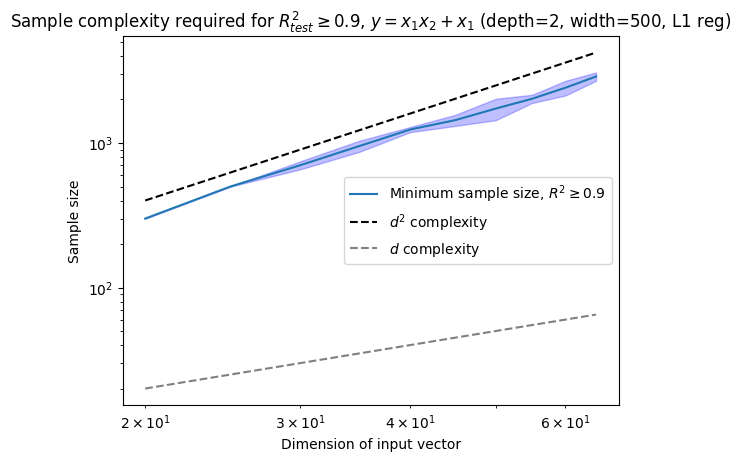

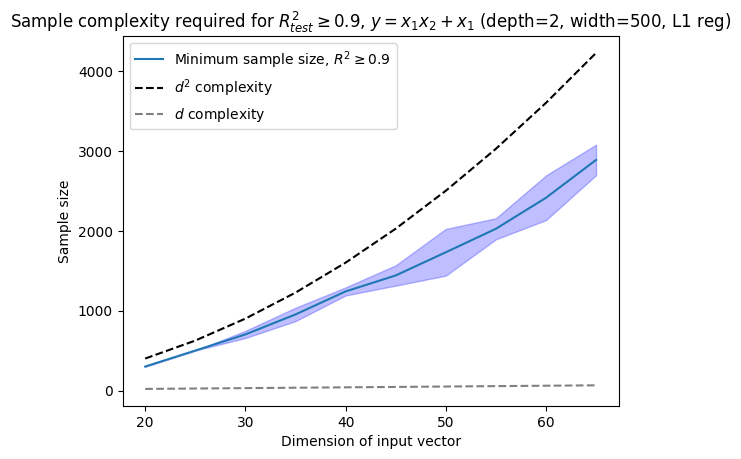

In [ ]:
#we plot the results in different scales
plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2 + x_1$'+" (depth=2, width=500, L1 reg)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2 + x_1$'+" (depth=2, width=500, L1 reg)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.show()

Learning non-MSP functions is still possible for 2HL NNs. Let's investigate the sample size required to do that, using f=x_1*x_2 .

In [ ]:
#learning h*=x_1*x_2 (non-MSP)
dimensions=np.linspace(20,65,10, dtype=int)
iters=5
sample_size_mean=[]
sample_size_std=[]
#dataset creation
for d in dimensions:
  N=[]
  for iter in range(iters):
    r2_test=0.91    #initializing r2 score
    n=(d+5)*d       #initializing sample size
    while r2_test >= 0.90:
      n=n-2*d       #exploring sample sizes with step 2d
      x_train = np.random.normal(size=(n,d))
      scaler.fit(x_train)
      x_train=scaler.transform(x_train)
      y = []
      for i in range(x_train.shape[0]):
        y.append(x_train[i][1]*x_train[i][2])
      y_train = np.array(y)

      x_test = np.random.normal(size=(100,d))
      scaler.fit(x_test)
      x_test=scaler.transform(x_test)
      y = []
      for i in range(x_test.shape[0]):
        y.append(x_test[i][1]*x_test[i][2])
      y_test = np.array(y)

      #depth=2, width=500 NN
      keras.backend.clear_session()
      train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
      train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

      inputs = keras.Input(shape=(d,), name="digits")
      layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
      layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
      outputs = Dense(1)(layer2)
      model = keras.Model(inputs=inputs, outputs=outputs)

      model.compile( metrics = ["mean_squared_error"] )

      loss_fn = keras.losses.MeanSquaredError()
      optimizer = keras.optimizers.SGD(0.01)
      train_acc_metric = keras.metrics.MeanSquaredError()
      train_loss_metric = keras.losses.MeanSquaredError()

      # Defining train step and test step
      @tf.function
      def train_step(x, y):
          with tf.GradientTape() as tape:
              logits = model(x, training=True)
              loss_value = loss_fn(y, logits)
          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
          train_acc_metric.update_state(y, logits)
          return loss_value

      @tf.function
      def test_step(x, y):
          val_logits = model(x, training=False)
          val_acc_metric.update_state(y, val_logits)


      # Training cycle
      epochs = 150
      for epoch in range(epochs):
          print("\nStart of epoch %d" % (epoch,))
          start_time = time.time()

          # Iterate over the batches of the dataset.
          for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
              loss_value = train_step(x_batch_train, y_batch_train)

          # Display metrics at the end of each epoch.
          train_acc = train_acc_metric.result()
          #if epoch==149:
            #tr_acc.append(train_acc.numpy())
          print("Training acc over epoch: %.4f" % (float(train_acc),))

          # Reset training metrics at the end of each epoch
          train_acc_metric.reset_states()

          print("Time taken: %.2fs" % (time.time() - start_time))
          print(str(n)+", "+str(d))

      model.evaluate(x_test,y_test)
      r2_test=sklearn.metrics.r2_score(y_test, model(x_test))
      print(r2_test)

    N.append(n+2*d)     #storing the smallest sample size that grants r2>=0.9 for each iter

  sample_size_mean.append(np.mean(np.array(N)))   #computing mean and std dev over iters
  sample_size_std.append(np.std(np.array(N)))


Output streaming troncato alle ultime 5000 righe.

Start of epoch 2
Training acc over epoch: 0.9335
Time taken: 0.22s
4420, 65

Start of epoch 3
Training acc over epoch: 0.9084
Time taken: 0.23s
4420, 65

Start of epoch 4
Training acc over epoch: 0.8807
Time taken: 0.22s
4420, 65

Start of epoch 5
Training acc over epoch: 0.8474
Time taken: 0.24s
4420, 65

Start of epoch 6
Training acc over epoch: 0.8172
Time taken: 0.23s
4420, 65

Start of epoch 7
Training acc over epoch: 0.7810
Time taken: 0.23s
4420, 65

Start of epoch 8
Training acc over epoch: 0.7483
Time taken: 0.23s
4420, 65

Start of epoch 9
Training acc over epoch: 0.6993
Time taken: 0.25s
4420, 65

Start of epoch 10
Training acc over epoch: 0.6641
Time taken: 0.23s
4420, 65

Start of epoch 11
Training acc over epoch: 0.6042
Time taken: 0.23s
4420, 65

Start of epoch 12
Training acc over epoch: 0.5485
Time taken: 0.23s
4420, 65

Start of epoch 13
Training acc over epoch: 0.4791
Time taken: 0.24s
4420, 65

Start of epoch 14
Tra

In [ ]:
#just a controll cell
print(sample_size_mean)
print(sample_size_std)

[492.0, 740.0, 1026.0, 1386.0, 1768.0, 2124.0, 2710.0, 3168.0, 3828.0, 4394.0]
[16.0, 20.0, 29.393876913398138, 28.0, 39.191835884530846, 91.78235124467012, 48.98979485566356, 161.66632302368976, 96.0, 97.28309205612247]


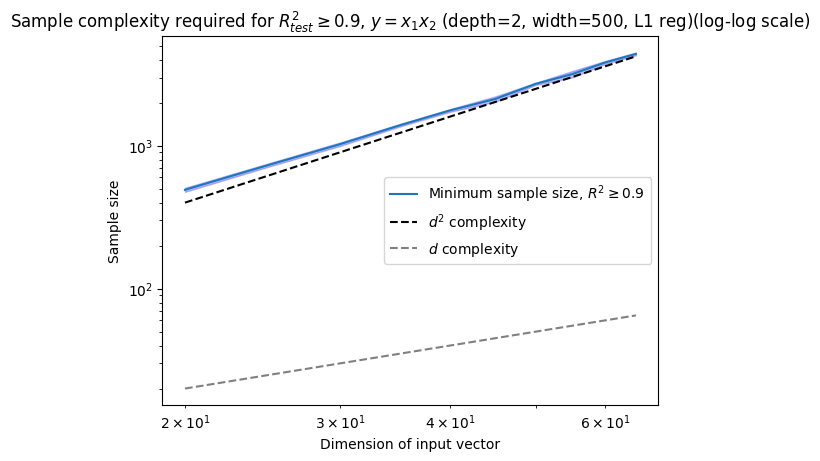

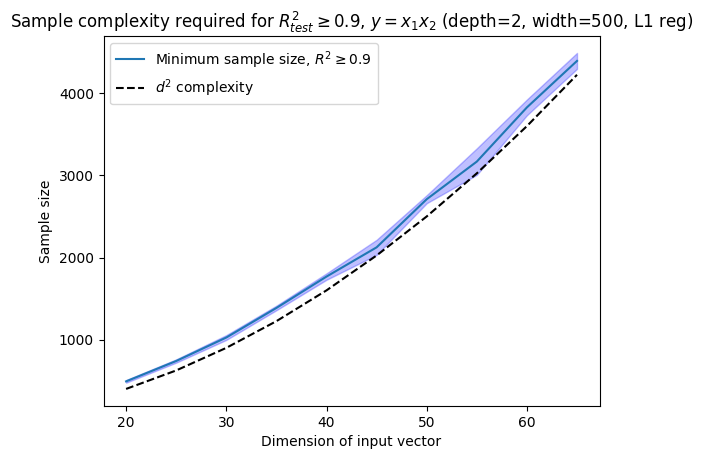

In [ ]:
#plotting results in two different scales
plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2$'+" (depth=2, width=500, L1 reg)(log-log scale)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
#plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2$'+" (depth=2, width=500, L1 reg)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.show()

What if we try to increase the number of relevant features?

In [ ]:
#learning h*=x_1*x_2*x_3 + x_1*x_2 + x_1 (MSP)
dimensions=np.linspace(30,75,10, dtype=int)
iters=5
sample_size_mean=[]
sample_size_std=[]
#dataset creation
for d in dimensions:
  N=[]
  for iter in range(iters):
    r2_test=0.91    #initializing r2
    n=(d+100)*d     #intializing sample size
    while r2_test >= 0.90:
      n=n-10*d      #exploring sample sizes with step 10d
      x_train = np.random.normal(size=(n,d))
      scaler.fit(x_train)
      x_train=scaler.transform(x_train)
      y = []
      for i in range(x_train.shape[0]):
        y.append(x_train[i][1]*x_train[i][2]*x_train[i][3] + x_train[i][1]*x_train[i][2] + x_train[i][1])
      y_train = np.array(y)

      x_test = np.random.normal(size=(100,d))
      scaler.fit(x_test)
      x_test=scaler.transform(x_test)
      y = []
      for i in range(x_test.shape[0]):
        y.append(x_test[i][1]*x_test[i][2]*x_test[i][3] + x_test[i][1]*x_test[i][2] + x_test[i][1])
      y_test = np.array(y)

      #depth=2, width=500 NN
      keras.backend.clear_session()
      train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
      train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

      inputs = keras.Input(shape=(d,), name="digits")
      layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
      layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
      outputs = Dense(1)(layer2)
      model = keras.Model(inputs=inputs, outputs=outputs)

      model.compile( metrics = ["mean_squared_error"] )

      loss_fn = keras.losses.MeanSquaredError()
      optimizer = keras.optimizers.SGD(0.01)
      train_acc_metric = keras.metrics.MeanSquaredError()
      train_loss_metric = keras.losses.MeanSquaredError()

      # Defining train step and test step
      @tf.function
      def train_step(x, y):
          with tf.GradientTape() as tape:
              logits = model(x, training=True)
              loss_value = loss_fn(y, logits)
          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
          train_acc_metric.update_state(y, logits)
          return loss_value

      @tf.function
      def test_step(x, y):
          val_logits = model(x, training=False)
          val_acc_metric.update_state(y, val_logits)


      # Training cycle
      epochs = 150
      for epoch in range(epochs):
          print("\nStart of epoch %d" % (epoch,))
          start_time = time.time()

          # Iterate over the batches of the dataset.
          for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
              loss_value = train_step(x_batch_train, y_batch_train)

          # Display metrics at the end of each epoch.
          train_acc = train_acc_metric.result()

          print("Training acc over epoch: %.4f" % (float(train_acc),))

          # Reset training metrics at the end of each epoch
          train_acc_metric.reset_states()

          print("Time taken: %.2fs" % (time.time() - start_time))
          print(str(n)+", "+str(d)) #just a control output

      model.evaluate(x_test,y_test)
      r2_test=sklearn.metrics.r2_score(y_test, model(x_test))
      print(r2_test)

    N.append(n+2*d)       #storing smallest sample size that grants r2>=0.9 for each iter

  sample_size_mean.append(np.mean(np.array(N)))  #computing mean and std dev over iters for each input dimension
  sample_size_std.append(np.std(np.array(N)))


Output streaming troncato alle ultime 5000 righe.

Start of epoch 2
Training acc over epoch: 1.6286
Time taken: 0.22s
12375, 75

Start of epoch 3
Training acc over epoch: 1.4081
Time taken: 0.31s
12375, 75

Start of epoch 4
Training acc over epoch: 1.1987
Time taken: 0.20s
12375, 75

Start of epoch 5
Training acc over epoch: 1.0340
Time taken: 0.21s
12375, 75

Start of epoch 6
Training acc over epoch: 0.9127
Time taken: 0.22s
12375, 75

Start of epoch 7
Training acc over epoch: 0.8377
Time taken: 0.31s
12375, 75

Start of epoch 8
Training acc over epoch: 0.7708
Time taken: 0.21s
12375, 75

Start of epoch 9
Training acc over epoch: 0.7096
Time taken: 0.30s
12375, 75

Start of epoch 10
Training acc over epoch: 0.6586
Time taken: 0.22s
12375, 75

Start of epoch 11
Training acc over epoch: 0.6011
Time taken: 0.20s
12375, 75

Start of epoch 12
Training acc over epoch: 0.5487
Time taken: 0.22s
12375, 75

Start of epoch 13
Training acc over epoch: 0.4978
Time taken: 0.21s
12375, 75

Start of 

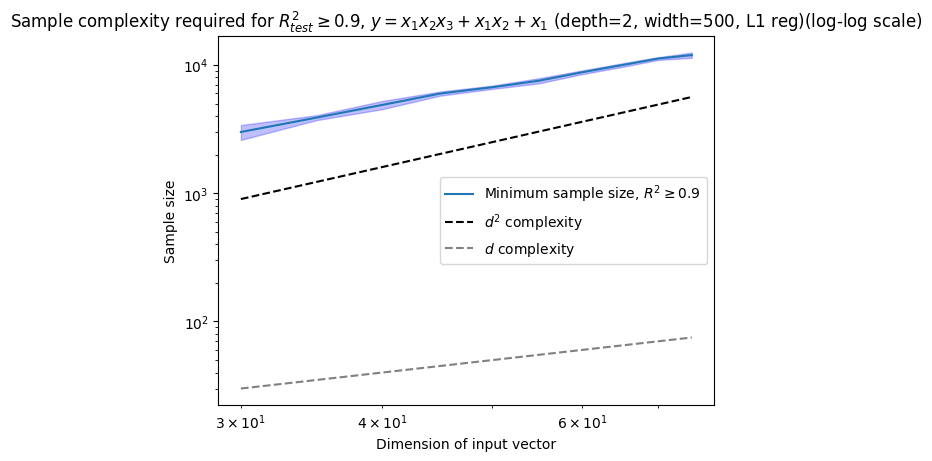

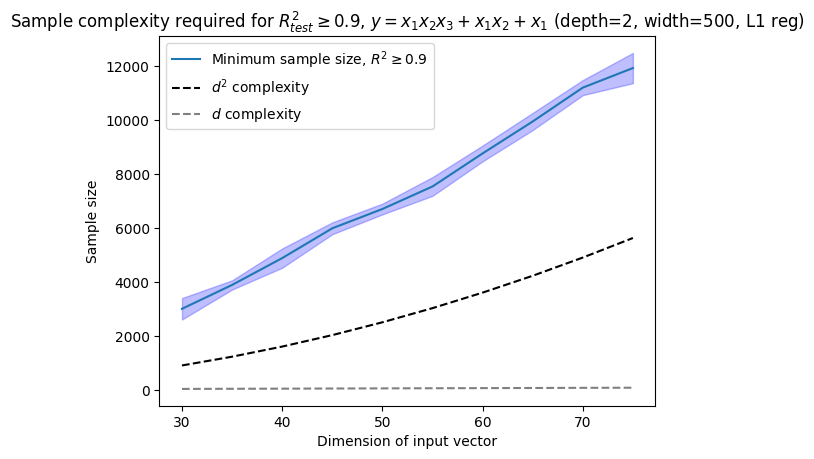

In [ ]:
#plotting results in different scales
plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2x_3 + x_1x_2 + x_1$'+" (depth=2, width=500, L1 reg)(log-log scale)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2x_3 + x_1x_2 + x_1$'+" (depth=2, width=500, L1 reg)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.show()

In [ ]:
#learning h*=x_1*x_2*x_3 (non-MSP)
dimensions=np.linspace(30,75,10, dtype=int)
iters=5
sample_size_mean=[]
sample_size_std=[]
#dataset creation
for d in dimensions:
  N=[]
  for iter in range(iters):
    r2_test=0.91      #initializing r2
    n=(d+500)*d       #intializing sample size
    while r2_test >= 0.90:
      n=n-100*d       #exploring sample sizes with step 100d
      x_train = np.random.normal(size=(n,d))
      scaler.fit(x_train)
      x_train=scaler.transform(x_train)
      y = []
      for i in range(x_train.shape[0]):
        y.append(x_train[i][1]*x_train[i][2]*x_train[i][3])
      y_train = np.array(y)

      x_test = np.random.normal(size=(100,d))
      scaler.fit(x_test)
      x_test=scaler.transform(x_test)
      y = []
      for i in range(x_test.shape[0]):
        y.append(x_test[i][1]*x_test[i][2]*x_test[i][3])
      y_test = np.array(y)

      #depth=2, width=500 NN
      keras.backend.clear_session()
      train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
      train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

      inputs = keras.Input(shape=(d,), name="digits")
      layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
      layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
      outputs = Dense(1)(layer2)
      model = keras.Model(inputs=inputs, outputs=outputs)

      model.compile( metrics = ["mean_squared_error"] )

      loss_fn = keras.losses.MeanSquaredError()
      optimizer = keras.optimizers.SGD(0.01)
      train_acc_metric = keras.metrics.MeanSquaredError()
      train_loss_metric = keras.losses.MeanSquaredError()

      # Defining train step and test step
      @tf.function
      def train_step(x, y):
          with tf.GradientTape() as tape:
              logits = model(x, training=True)
              loss_value = loss_fn(y, logits)
          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
          train_acc_metric.update_state(y, logits)
          return loss_value

      @tf.function
      def test_step(x, y):
          val_logits = model(x, training=False)
          val_acc_metric.update_state(y, val_logits)


      # Training cycle
      epochs = 150
      for epoch in range(epochs):
          print("\nStart of epoch %d" % (epoch,))
          start_time = time.time()

          # Iterate over the batches of the dataset.
          for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
              loss_value = train_step(x_batch_train, y_batch_train)

          # Display metrics at the end of each epoch.
          train_acc = train_acc_metric.result()

          print("Training acc over epoch: %.4f" % (float(train_acc),))

          # Reset training metrics at the end of each epoch
          train_acc_metric.reset_states()

          print("Time taken: %.2fs" % (time.time() - start_time))
          print(str(n)+", "+str(d)) #just a control output

      model.evaluate(x_test,y_test)
      r2_test=sklearn.metrics.r2_score(y_test, model(x_test))
      print(r2_test)

    N.append(n+2*d)   #storing smallest sample size that grants r2>=0.9 for each iter

  sample_size_mean.append(np.mean(np.array(N)))     #computing mean and std over iters for each input dimensions
  sample_size_std.append(np.std(np.array(N)))


Output streaming troncato alle ultime 5000 righe.

Start of epoch 2
Training acc over epoch: 1.0085
Time taken: 1.70s
35625, 75

Start of epoch 3
Training acc over epoch: 0.9962
Time taken: 1.66s
35625, 75

Start of epoch 4
Training acc over epoch: 0.9865
Time taken: 1.70s
35625, 75

Start of epoch 5
Training acc over epoch: 0.9749
Time taken: 1.75s
35625, 75

Start of epoch 6
Training acc over epoch: 0.9641
Time taken: 2.86s
35625, 75

Start of epoch 7
Training acc over epoch: 0.9483
Time taken: 1.87s
35625, 75

Start of epoch 8
Training acc over epoch: 0.9359
Time taken: 1.66s
35625, 75

Start of epoch 9
Training acc over epoch: 0.9177
Time taken: 1.67s
35625, 75

Start of epoch 10
Training acc over epoch: 0.8985
Time taken: 1.68s
35625, 75

Start of epoch 11
Training acc over epoch: 0.8773
Time taken: 1.66s
35625, 75

Start of epoch 12
Training acc over epoch: 0.8510
Time taken: 1.69s
35625, 75

Start of epoch 13
Training acc over epoch: 0.8181
Time taken: 2.76s
35625, 75

Start of 

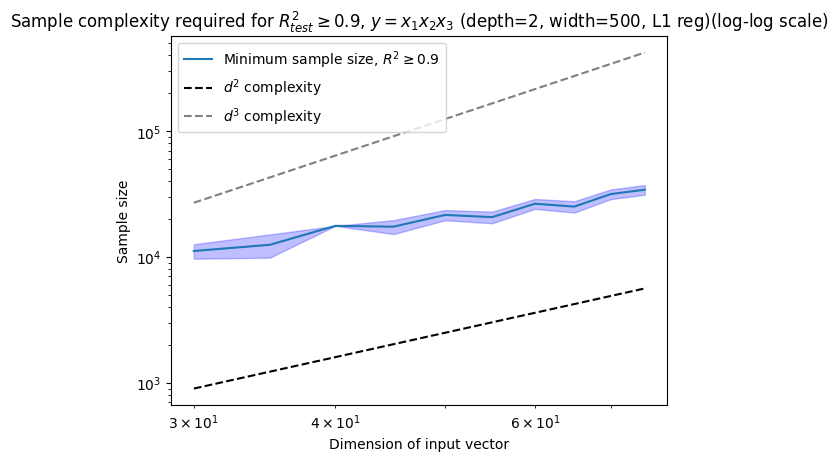

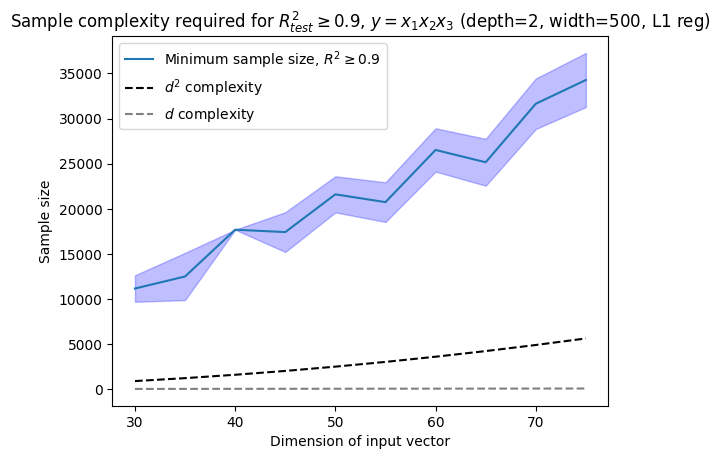

In [ ]:
#plotting results in different scales
plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, np.power(dimensions, 3), color='gray', linestyle='--', label="$d^3$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2x_3$'+" (depth=2, width=500, L1 reg)(log-log scale)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.plot(dimensions,sample_size_mean, label="Minimum sample size, $R^2 \geq 0.9$ ")
plt.fill_between(dimensions, np.array(sample_size_mean)+np.array(sample_size_std) , np.array(sample_size_mean)-np.array(sample_size_std) ,color='b', alpha = 0.25)
plt.plot(dimensions, np.square(dimensions),color='black', linestyle='--', label="$d^2$ complexity")
plt.plot(dimensions, dimensions, color='gray', linestyle='--', label="$d$ complexity")
plt.title("Sample complexity required for $R^2_{test} \geq 0.9$, "+'$y = x_1x_2x_3$'+" (depth=2, width=500, L1 reg)")
plt.xlabel("Dimension of input vector")
plt.ylabel("Sample size")
plt.legend()
plt.show()

Why are MSP functions so much easier to learn than non-MSPs? Let's look into the feature learning process of the NN by comparing the outer product of the weight matrix in those two cases, taking a d=40 input and the same sample size for both. (Appendix material)
First, we look into the MSP case f=x_1*x_2*x_3 + x_1*x_2 + x_1

In [ ]:
#learning y=x_1 + x_1x_2 + x_1x_2x_3 (MSP)
x_train = np.random.normal(size=(3000,40))
scaler.fit(x_train)
x_train=scaler.transform(x_train)
y = []
for i in range(x_train.shape[0]):
  y.append(x_train[i][1]*x_train[i][2]*x_train[i][3]+x_train[i][1]*x_train[i][2]+x_train[i][1])
y_train = np.array(y)

x_test = np.random.normal(size=(2000,40))
scaler.fit(x_test)
x_test=scaler.transform(x_test)
y = []
for i in range(x_test.shape[0]):
  y.append(x_test[i][1]*x_test[i][2]*x_test[i][3]+x_test[i][1]*x_test[i][2]+x_test[i][1])
y_test = np.array(y)

#depth 2 NN

keras.backend.clear_session()
train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

inputs = keras.Input(shape=(40,), name="digits")
layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
outputs = Dense(1)(layer2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile( metrics = ["mean_squared_error"] )

loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.SGD(0.01)
train_acc_metric = keras.metrics.MeanSquaredError()
train_loss_metric = keras.losses.MeanSquaredError()

# Defining train step and test step
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)


# Training cycle
epochs = 150
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()

    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    print("Time taken: %.2fs" % (time.time() - start_time))

model.evaluate(x_test, y_test)
print("R2 test:", sklearn.metrics.r2_score(y_test, model(x_test)))

matrix_msp = np.dot(model.get_weights()[0],model.get_weights()[0].T) #computing first layer W matrix outer product
flattened_matrix = matrix_msp.flatten()
sorted_vector = np.sort(flattened_matrix)[::-1]  #sorting matrix elements in decreasing order
indexes=[np.where(matrix_msp == sorted_vector[0]), np.where(matrix_msp == sorted_vector[1]), np.where(matrix_msp == sorted_vector[2])] #accessing indexes of top 3 elements
print(indexes)
print(sorted_vector[0], "  ", sorted_vector[1], "  ", sorted_vector[2]) #printig associated values
print("Peso relativo alle altre feature:", abs(np.mean(sorted_vector[0:2])/np.mean(sorted_vector[3:-1]))) #computing average weight relative to the average weight of other elements


Start of epoch 0
Training acc over epoch: 2.7973
Time taken: 1.48s

Start of epoch 1
Training acc over epoch: 2.4079
Time taken: 0.07s

Start of epoch 2
Training acc over epoch: 2.1342
Time taken: 0.14s

Start of epoch 3
Training acc over epoch: 1.9048
Time taken: 0.14s

Start of epoch 4
Training acc over epoch: 1.7739
Time taken: 0.15s

Start of epoch 5
Training acc over epoch: 1.6779
Time taken: 0.07s

Start of epoch 6
Training acc over epoch: 1.5833
Time taken: 0.07s

Start of epoch 7
Training acc over epoch: 1.4986
Time taken: 0.14s

Start of epoch 8
Training acc over epoch: 1.4110
Time taken: 0.07s

Start of epoch 9
Training acc over epoch: 1.3206
Time taken: 0.07s

Start of epoch 10
Training acc over epoch: 1.2520
Time taken: 0.08s

Start of epoch 11
Training acc over epoch: 1.1713
Time taken: 0.08s

Start of epoch 12
Training acc over epoch: 1.1103
Time taken: 0.07s

Start of epoch 13
Training acc over epoch: 1.0304
Time taken: 0.15s

Start of epoch 14
Training acc over epoch: 

Now, the non-MSP case f=x_1*x_2*x_3

In [ ]:
#using x_train and x_test from previous cell
y = []
for i in range(x_train.shape[0]):
  y.append(x_train[i][1]*x_train[i][2]*x_train[i][3])
y_train = np.array(y)

y = []
for i in range(x_test.shape[0]):
  y.append(x_test[i][1]*x_test[i][2]*x_test[i][3])
y_test = np.array(y)

#depth 2 NN

keras.backend.clear_session()
train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

inputs = keras.Input(shape=(40,), name="digits")
layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
outputs = Dense(1)(layer2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile( metrics = ["mean_squared_error"] )

loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.SGD(0.01)
train_acc_metric = keras.metrics.MeanSquaredError()
train_loss_metric = keras.losses.MeanSquaredError()

# Defining train step and test step
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)


# Training cycle
epochs = 150
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    #if epoch==149:
      #tr_acc.append(train_acc.numpy())
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    print("Time taken: %.2fs" % (time.time() - start_time))

model.evaluate(x_test, y_test)
print("R2 test:", sklearn.metrics.r2_score(y_test, model(x_test)))

matrix_notmsp = np.dot(model.get_weights()[0],model.get_weights()[0].T) #same process as the previous cell
flattened_matrix = matrix_notmsp.flatten()
sorted_vector_notmsp = np.sort(flattened_matrix)[::-1]
indexes_notmsp=[np.where(matrix_notmsp == sorted_vector_notmsp[0]), np.where(matrix_notmsp == sorted_vector_notmsp[1]), np.where(matrix_notmsp == sorted_vector_notmsp[2])]
print(indexes_notmsp)
print(sorted_vector_notmsp[0], "  ", sorted_vector_notmsp[1], "  ", sorted_vector_notmsp[2])
print("Peso relativo alle altre feature:", abs(np.mean(sorted_vector_notmsp[0:2])/np.mean(sorted_vector_notmsp[3:-1])))


Start of epoch 0
Training acc over epoch: 1.0878
Time taken: 1.28s

Start of epoch 1
Training acc over epoch: 1.0461
Time taken: 0.15s

Start of epoch 2
Training acc over epoch: 1.0396
Time taken: 0.15s

Start of epoch 3
Training acc over epoch: 1.0148
Time taken: 0.14s

Start of epoch 4
Training acc over epoch: 0.9979
Time taken: 0.15s

Start of epoch 5
Training acc over epoch: 0.9868
Time taken: 0.14s

Start of epoch 6
Training acc over epoch: 0.9905
Time taken: 0.08s

Start of epoch 7
Training acc over epoch: 0.9927
Time taken: 0.14s

Start of epoch 8
Training acc over epoch: 0.9556
Time taken: 0.14s

Start of epoch 9
Training acc over epoch: 0.9419
Time taken: 0.08s

Start of epoch 10
Training acc over epoch: 0.9326
Time taken: 0.07s

Start of epoch 11
Training acc over epoch: 0.9180
Time taken: 0.07s

Start of epoch 12
Training acc over epoch: 0.9058
Time taken: 0.14s

Start of epoch 13
Training acc over epoch: 0.9135
Time taken: 0.08s

Start of epoch 14
Training acc over epoch: 

Let's compare the images of the two matrices side by side

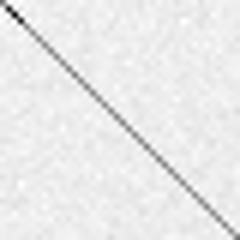

In [ ]:
#MSP matrix
max_value = sorted_vector[0]
min_value = sorted_vector[-1]
normalized_matrix_msp = ((matrix_msp - min_value) / (max_value - min_value)) * 255
normalized_matrix_msp = normalized_matrix_msp.astype(np.uint8)
normalized_matrix_msp = 255 - normalized_matrix_msp

from PIL import Image
image = Image.fromarray(normalized_matrix_msp)
new_size = (image.width * 6, image.height * 6)
resized_image_msp = image.resize(new_size)
resized_image_msp

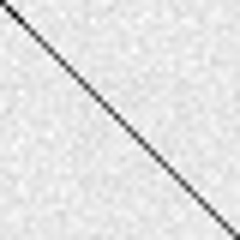

In [ ]:
#Not MSP matrix
max_value = sorted_vector_notmsp[0]
min_value = sorted_vector_notmsp[-1]
normalized_matrix_notmsp = ((matrix_notmsp - min_value) / (max_value - min_value)) * 255
normalized_matrix_notmsp = normalized_matrix_notmsp.astype(np.uint8)
normalized_matrix_notmsp = 255 - normalized_matrix_notmsp

from PIL import Image
image = Image.fromarray(normalized_matrix_notmsp)
new_size = (image.width * 6, image.height * 6)
resized_image_notmsp = image.resize(new_size)
resized_image_notmsp

Let's study the dymanics of the $W^TW$ matrix during training for both MSP and non-MSP functions.

In [ ]:
#learning y=x_1 + x_1x_2 + x_1x_2x_3 (MSP)
x_train = np.random.normal(size=(5000,40))
scaler.fit(x_train)
x_train=scaler.transform(x_train)
y = []
for i in range(x_train.shape[0]):
  y.append(x_train[i][1]*x_train[i][2]*x_train[i][3]+x_train[i][1]*x_train[i][2]+x_train[i][1])
y_train = np.array(y)

x_test = np.random.normal(size=(2000,40))
scaler.fit(x_test)
x_test=scaler.transform(x_test)
y = []
for i in range(x_test.shape[0]):
  y.append(x_test[i][1]*x_test[i][2]*x_test[i][3]+x_test[i][1]*x_test[i][2]+x_test[i][1])
y_test = np.array(y)

#depth 2 NN
iters=10
r2=[]   #auxiliary variables to store results for each iteration
w_1=[]
w_2=[]
w_3=[]

for iter in range(iters):

  keras.backend.clear_session()
  train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  inputs = keras.Input(shape=(40,), name="digits")
  layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
  layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
  outputs = Dense(1)(layer2)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile( metrics = ["mean_squared_error"] )

  loss_fn = keras.losses.MeanSquaredError()
  optimizer = keras.optimizers.SGD(0.01)
  train_acc_metric = keras.metrics.MeanSquaredError()
  train_loss_metric = keras.losses.MeanSquaredError()

  # Defining train step and test step
  @tf.function
  def train_step(x, y):
    with tf.GradientTape() as tape:
      logits = model(x, training=True)
      loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

  @tf.function
  def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)


  # Training cycle
  epochs = 150
  for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      loss_value = train_step(x_batch_train, y_batch_train)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()

    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    print("Time taken: %.2fs" % (time.time() - start_time))
    matrix = np.dot(model.get_weights()[0],model.get_weights()[0].T) #first layer W matrix outer product
    w_1.append(matrix[1][1]) #storing diagonal elements relative to the relevant features
    w_2.append(matrix[2][2])
    w_3.append(matrix[3][3])


  model.evaluate(x_test, y_test)
  print("R2 test:", sklearn.metrics.r2_score(y_test, model(x_test)))
  r2.append(sklearn.metrics.r2_score(y_test, model(x_test)))
w_1_mean=np.mean(np.reshape(np.array(w_1), (10,150)), axis=0) #computing mean and std dev over iters
w_1_std=np.std(np.reshape(np.array(w_1), (10,150)), axis=0)
w_2_mean=np.mean(np.reshape(np.array(w_2), (10,150)), axis=0)
w_2_std=np.std(np.reshape(np.array(w_2), (10,150)), axis=0)
w_3_mean=np.mean(np.reshape(np.array(w_3), (10,150)), axis=0)
w_3_std=np.std(np.reshape(np.array(w_3), (10,150)), axis=0)
print(w_1_mean.shape) #just a control output

Output streaming troncato alle ultime 5000 righe.
Time taken: 0.11s

Start of epoch 105
Training acc over epoch: 0.0183
Time taken: 0.10s

Start of epoch 106
Training acc over epoch: 0.0169
Time taken: 0.11s

Start of epoch 107
Training acc over epoch: 0.0162
Time taken: 0.10s

Start of epoch 108
Training acc over epoch: 0.0157
Time taken: 0.14s

Start of epoch 109
Training acc over epoch: 0.0151
Time taken: 0.14s

Start of epoch 110
Training acc over epoch: 0.0151
Time taken: 0.12s

Start of epoch 111
Training acc over epoch: 0.0149
Time taken: 0.14s

Start of epoch 112
Training acc over epoch: 0.0147
Time taken: 0.11s

Start of epoch 113
Training acc over epoch: 0.0144
Time taken: 0.11s

Start of epoch 114
Training acc over epoch: 0.0134
Time taken: 0.14s

Start of epoch 115
Training acc over epoch: 0.0140
Time taken: 0.14s

Start of epoch 116
Training acc over epoch: 0.0131
Time taken: 0.14s

Start of epoch 117
Training acc over epoch: 0.0129
Time taken: 0.14s

Start of epoch 118
Tr

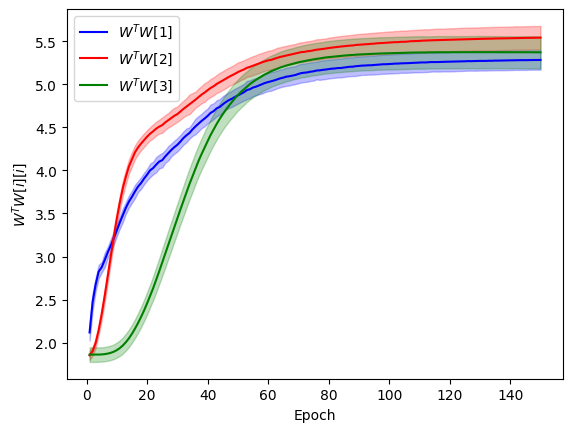

In [ ]:
#plotting results (MSP)
plt.plot(np.linspace(1,150,150, dtype=int), w_1_mean, color='b', label="$W^TW[1]$")
plt.fill_between(np.linspace(1,150,150, dtype=int), w_1_mean+w_1_std, w_1_mean-w_1_std, color='b', alpha=0.25)
plt.plot(np.linspace(1,150,150, dtype=int), w_2_mean, color='r', label="$W^TW[2]$")
plt.fill_between(np.linspace(1,150,150, dtype=int), w_2_mean+w_2_std, w_2_mean-w_2_std, color='r', alpha=0.25)
plt.plot(np.linspace(1,150,150, dtype=int), w_3_mean, color='g', label="$W^TW[3]$")
plt.fill_between(np.linspace(1,150,150, dtype=int), w_3_mean+w_3_std, w_3_mean-w_3_std, color='g', alpha=0.25)
#plt.title("Evolution of $W^TW$ learning $y=x_1+x_1x_2+x_1x_2x_3$ during training (depth=2, width=500, L1 reg)")
plt.xlabel("Epoch")
plt.ylabel("$W^TW[i][i]$")
plt.legend()
plt.show()

In [ ]:
#learning y=x_1x_2x_3(non-MSP)
x_train = np.random.normal(size=(5000,40))
scaler.fit(x_train)
x_train=scaler.transform(x_train)
y = []
for i in range(x_train.shape[0]):
  y.append(x_train[i][1]*x_train[i][2]*x_train[i][3])
y_train = np.array(y)

x_test = np.random.normal(size=(2000,40))
scaler.fit(x_test)
x_test=scaler.transform(x_test)
y = []
for i in range(x_test.shape[0]):
  y.append(x_test[i][1]*x_test[i][2]*x_test[i][3])
y_test = np.array(y)

#depth 2 NN
iters=10
r2=[]  #auxiliary variables
w_1=[]
w_2=[]
w_3=[]

for iter in range(iters):
  keras.backend.clear_session()
  train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

  inputs = keras.Input(shape=(40,), name="digits")
  layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
  layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
  outputs = Dense(1)(layer2)
  model = keras.Model(inputs=inputs, outputs=outputs)

  model.compile( metrics = ["mean_squared_error"] )

  loss_fn = keras.losses.MeanSquaredError()
  optimizer = keras.optimizers.SGD(0.01)
  train_acc_metric = keras.metrics.MeanSquaredError()
  train_loss_metric = keras.losses.MeanSquaredError()

  # Defining train step and test step
  @tf.function
  def train_step(x, y):
    with tf.GradientTape() as tape:
      logits = model(x, training=True)
      loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

  @tf.function
  def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)


  # Training cycle
  epochs = 150
  for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
      loss_value = train_step(x_batch_train, y_batch_train)

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()

    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    print("Time taken: %.2fs" % (time.time() - start_time))
    matrix = np.dot(model.get_weights()[0],model.get_weights()[0].T) #first layer W matrxi outer product
    w_1.append(matrix[1][1])  #storing diagonal elements relative to relevant features
    w_2.append(matrix[2][2])
    w_3.append(matrix[3][3])


  model.evaluate(x_test, y_test)
  print("R2 test:", sklearn.metrics.r2_score(y_test, model(x_test)))
  r2.append(sklearn.metrics.r2_score(y_test, model(x_test)))   #computing mean and std dev over iters
w_1_mean=np.mean(np.reshape(np.array(w_1), (10,150)), axis=0)
w_1_std=np.std(np.reshape(np.array(w_1), (10,150)), axis=0)
w_2_mean=np.mean(np.reshape(np.array(w_2), (10,150)), axis=0)
w_2_std=np.std(np.reshape(np.array(w_2), (10,150)), axis=0)
w_3_mean=np.mean(np.reshape(np.array(w_3), (10,150)), axis=0)
w_3_std=np.std(np.reshape(np.array(w_3), (10,150)), axis=0)
print(w_1_mean.shape) #just a control output

Output streaming troncato alle ultime 5000 righe.
Time taken: 0.11s

Start of epoch 105
Training acc over epoch: 0.0283
Time taken: 0.10s

Start of epoch 106
Training acc over epoch: 0.0351
Time taken: 0.10s

Start of epoch 107
Training acc over epoch: 0.0423
Time taken: 0.10s

Start of epoch 108
Training acc over epoch: 0.0288
Time taken: 0.10s

Start of epoch 109
Training acc over epoch: 0.0290
Time taken: 0.10s

Start of epoch 110
Training acc over epoch: 0.0298
Time taken: 0.10s

Start of epoch 111
Training acc over epoch: 0.0402
Time taken: 0.11s

Start of epoch 112
Training acc over epoch: 0.0324
Time taken: 0.14s

Start of epoch 113
Training acc over epoch: 0.0389
Time taken: 0.10s

Start of epoch 114
Training acc over epoch: 0.0406
Time taken: 0.11s

Start of epoch 115
Training acc over epoch: 0.0228
Time taken: 0.14s

Start of epoch 116
Training acc over epoch: 0.0295
Time taken: 0.10s

Start of epoch 117
Training acc over epoch: 0.0645
Time taken: 0.11s

Start of epoch 118
Tr

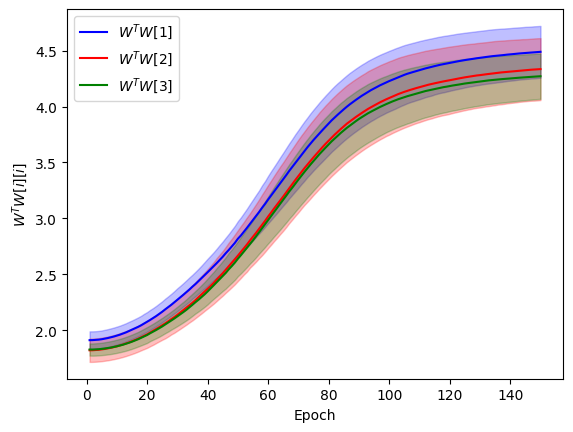

In [ ]:
#plotting results (non-MSP)
plt.plot(np.linspace(1,150,150, dtype=int), w_1_mean, color='b', label="$W^TW[1]$")
plt.fill_between(np.linspace(1,150,150, dtype=int), w_1_mean+w_1_std, w_1_mean-w_1_std, color='b', alpha=0.25)
plt.plot(np.linspace(1,150,150, dtype=int), w_2_mean, color='r', label="$W^TW[2]$")
plt.fill_between(np.linspace(1,150,150, dtype=int), w_2_mean+w_2_std, w_2_mean-w_2_std, color='r', alpha=0.25)
plt.plot(np.linspace(1,150,150, dtype=int), w_3_mean, color='g', label="$W^TW[3]$")
plt.fill_between(np.linspace(1,150,150, dtype=int), w_3_mean+w_3_std, w_3_mean-w_3_std, color='g', alpha=0.25)
#plt.title("Evolution of $W^TW$ learning $y=x_1+x_1x_2+x_1x_2x_3$ during training (depth=2, width=500, L1 reg)")
plt.xlabel("Epoch")
plt.ylabel("$W^TW[i][i]$")
plt.legend()
plt.show()

Data augmentation on $y=x_jx_k$ (j,k sampled from integre uniform dist), d=40

In [ ]:
j=np.random.randint(0,40) #sampling relevant features
k=np.random.randint(0,40)
multiplier=np.linspace(1,5,5,dtype=int) #augmentation size
N=[] #auxiliary variables
r2_base=[]
r2_mean=[]
r2_std=[]
iters=5
for m in multiplier:
  r2_aug=[]
  for iter in range(iters):
    x_train = np.random.normal(size=(1000,40)) #first run of training
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    y = []
    for i in range(x_train.shape[0]):
      y.append(x_train[i][j]*x_train[i][k])
    y_train = np.array(y)

    x_test = np.random.normal(size=(500,40))
    scaler.fit(x_test)
    x_test=scaler.transform(x_test)
    y = []
    for i in range(x_test.shape[0]):
      y.append(x_test[i][j]*x_test[i][k])
    y_test = np.array(y)
    #depth=2, width=500 NN
    keras.backend.clear_session()
    train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    inputs = keras.Input(shape=(40,), name="digits")
    layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
    layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
    outputs = Dense(1)(layer2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile( metrics = ["mean_squared_error"] )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.SGD(0.01)
    train_acc_metric = keras.metrics.MeanSquaredError()
    train_loss_metric = keras.losses.MeanSquaredError()

    #Defining train step and test step
    @tf.function
    def train_step(x, y):
      with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
      grads = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      train_acc_metric.update_state(y, logits)
      return loss_value

    @tf.function
    def test_step(x, y):
      val_logits = model(x, training=False)
      val_acc_metric.update_state(y, val_logits)

    # Training cycle
    epochs = 150
    for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        #Display metrics at the end of each epoch.
      train_acc = train_acc_metric.result()

      print("Training acc over epoch: %.4f" % (float(train_acc),))

      # Reset training metrics at the end of each epoch
      train_acc_metric.reset_states()

      print("Time taken: %.2fs" % (time.time() - start_time))


    model.evaluate(x_test,y_test)
    r2_base.append(sklearn.metrics.r2_score(y_test, model(x_test))) #storing baseline performance with no augmentation


    matrix = np.dot(model.get_weights()[0],model.get_weights()[0].T) #first layer W matrxi outer product
    flattened_matrix =[]
    for i in range(40):   #storing diagonal elements
      flattened_matrix.append(matrix[i][i])
    sorted_vector = np.sort(np.array(flattened_matrix))[::-1] #sorting diagonal elements in decreasing order
    indexes_top=[np.where(matrix == sorted_vector[0]), np.where(matrix == sorted_vector[1]), np.where(matrix == sorted_vector[2])]  #some control outputs
    indexes_low=[np.where(matrix == sorted_vector[-3]), np.where(matrix == sorted_vector[-2]), np.where(matrix == sorted_vector[-1])]
    print(indexes_top)
    print(sorted_vector[0], "  ", sorted_vector[1], "  ", sorted_vector[2])
    print(indexes_low)
    print(sorted_vector[-3], "  ", sorted_vector[-2], "  ", sorted_vector[-1])
    z=np.where(matrix==sorted_vector[-1])[0][0]   #storing the 3 features with the lowest values
    v=np.where(matrix==sorted_vector[-2])[0][0]
    w=np.where(matrix==sorted_vector[-3])[0][0]

    x_train_aux=x_train #augmentation: create copy of the dataset, resample the 3 features define above and then add the new examples to the original training set
    for _ in range(m):
      new_x_train=x_train_aux
      for i in range(x_train_aux.shape[0]):
        new_x_train[i][z]=np.random.normal()
        new_x_train[i][v]=np.random.normal()
        new_x_train[i][w]=np.random.normal()
      x_train=np.append(x_train, new_x_train, axis=0)
    y=[]
    for i in range(x_train.shape[0]):
      y.append(x_train[i][j]*x_train[i][k])
    y_train = np.array(y)
    #second run of training
    #depth=2, width=500 NN
    keras.backend.clear_session()
    train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    inputs = keras.Input(shape=(40,), name="digits")
    layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
    layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
    outputs = Dense(1)(layer2)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile( metrics = ["mean_squared_error"] )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.SGD(0.01)
    train_acc_metric = keras.metrics.MeanSquaredError()
    train_loss_metric = keras.losses.MeanSquaredError()

    #Defining train step and test step
    @tf.function
    def train_step(x, y):
      with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
      grads = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      train_acc_metric.update_state(y, logits)
      return loss_value

    @tf.function
    def test_step(x, y):
      val_logits = model(x, training=False)
      val_acc_metric.update_state(y, val_logits)

    # Training cycle
    epochs = 150
    for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

      # Display metrics at the end of each epoch.
      train_acc = train_acc_metric.result()

      print("Training acc over epoch: %.4f" % (float(train_acc),))

      # Reset training metrics at the end of each epoch
      train_acc_metric.reset_states()

      print("Time taken: %.2fs" % (time.time() - start_time))
    model.evaluate(x_test, y_test)
    r2_aug.append(sklearn.metrics.r2_score(y_test, model(x_test))) #storing performance after augmentation for each run

  r2_mean.append(np.mean(np.array(r2_aug)))  #computing mean and std dev over iters for each new sample size
  r2_std.append(np.std(np.array(r2_aug)))
  N.append(x_train.shape[0]) #storing augmented sample size

Output streaming troncato alle ultime 5000 righe.
Training acc over epoch: 0.0014
Time taken: 0.15s

Start of epoch 107
Training acc over epoch: 0.0014
Time taken: 0.31s

Start of epoch 108
Training acc over epoch: 0.0014
Time taken: 0.30s

Start of epoch 109
Training acc over epoch: 0.0014
Time taken: 0.31s

Start of epoch 110
Training acc over epoch: 0.0014
Time taken: 0.09s

Start of epoch 111
Training acc over epoch: 0.0013
Time taken: 0.09s

Start of epoch 112
Training acc over epoch: 0.0013
Time taken: 0.10s

Start of epoch 113
Training acc over epoch: 0.0013
Time taken: 0.09s

Start of epoch 114
Training acc over epoch: 0.0013
Time taken: 0.09s

Start of epoch 115
Training acc over epoch: 0.0013
Time taken: 0.10s

Start of epoch 116
Training acc over epoch: 0.0013
Time taken: 0.10s

Start of epoch 117
Training acc over epoch: 0.0013
Time taken: 0.09s

Start of epoch 118
Training acc over epoch: 0.0012
Time taken: 0.15s

Start of epoch 119
Training acc over epoch: 0.0012
Time tak

In [ ]:
#training NN on true datasets matching augmented sample sizes, to establish comparison
r2_true_size=[]
for n in N:
  R2=[]
  for iter in range(iters):
    x_train = np.random.normal(size=(n,40))
    scaler.fit(x_train)
    x_train=scaler.transform(x_train)
    y = []
    for i in range(x_train.shape[0]):
      y.append(x_train[i][j]*x_train[i][k])
    y_train = np.array(y)

    x_test = np.random.normal(size=(500,40))
    scaler.fit(x_test)
    x_test=scaler.transform(x_test)
    y = []
    for i in range(x_test.shape[0]):
      y.append(x_test[i][j]*x_test[i][k])
    y_test = np.array(y)
    #depth=2, width=500 NN
    keras.backend.clear_session()
    train_dataset= tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    inputs = keras.Input(shape=(40,), name="digits")
    layer1 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(inputs)
    layer2 = Dense(500, activation="relu", kernel_regularizer=regularizers.L1(l1=0.02))(layer1)
    outputs = Dense(1)(layer2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile( metrics = ["mean_squared_error"] )

    loss_fn = keras.losses.MeanSquaredError()
    optimizer = keras.optimizers.SGD(0.01)
    train_acc_metric = keras.metrics.MeanSquaredError()
    train_loss_metric = keras.losses.MeanSquaredError()

    #Defining train step and test step
    @tf.function
    def train_step(x, y):
      with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
      grads = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      train_acc_metric.update_state(y, logits)
      return loss_value

    @tf.function
    def test_step(x, y):
      val_logits = model(x, training=False)
      val_acc_metric.update_state(y, val_logits)

    # Training cycle
    epochs = 150
    for epoch in range(epochs):
      print("\nStart of epoch %d" % (epoch,))
      start_time = time.time()

      # Iterate over the batches of the dataset.
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        #Display metrics at the end of each epoch.
      train_acc = train_acc_metric.result()
      #if epoch==149:
        #tr_acc.append(train_acc.numpy())
      print("Training acc over epoch: %.4f" % (float(train_acc),))

      # Reset training metrics at the end of each epoch
      train_acc_metric.reset_states()

      print("Time taken: %.2fs" % (time.time() - start_time))
      #Defining train step and test step
    model.evaluate(x_test,y_test)
    R2.append(sklearn.metrics.r2_score(y_test, model(x_test)))
  r2_true_size.append(np.mean(np.array(R2)))

Output streaming troncato alle ultime 5000 righe.
Training acc over epoch: 0.0091
Time taken: 0.08s

Start of epoch 103
Training acc over epoch: 0.0091
Time taken: 0.08s

Start of epoch 104
Training acc over epoch: 0.0090
Time taken: 0.08s

Start of epoch 105
Training acc over epoch: 0.0091
Time taken: 0.09s

Start of epoch 106
Training acc over epoch: 0.0087
Time taken: 0.14s

Start of epoch 107
Training acc over epoch: 0.0086
Time taken: 0.08s

Start of epoch 108
Training acc over epoch: 0.0086
Time taken: 0.08s

Start of epoch 109
Training acc over epoch: 0.0086
Time taken: 0.08s

Start of epoch 110
Training acc over epoch: 0.0083
Time taken: 0.09s

Start of epoch 111
Training acc over epoch: 0.0083
Time taken: 0.15s

Start of epoch 112
Training acc over epoch: 0.0081
Time taken: 0.09s

Start of epoch 113
Training acc over epoch: 0.0081
Time taken: 0.08s

Start of epoch 114
Training acc over epoch: 0.0079
Time taken: 0.08s

Start of epoch 115
Training acc over epoch: 0.0080
Time tak

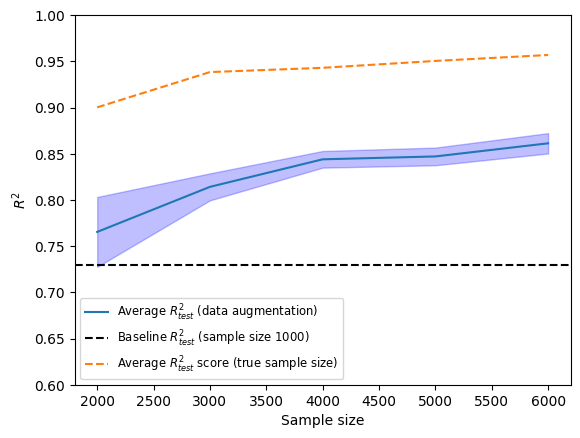

In [ ]:
#plotting results
plt.plot(N, r2_mean, label="Average $R^2_{test}$ (data augmentation)")
plt.fill_between(N, np.array(r2_mean)+np.array(r2_std) , np.array(r2_mean)-np.array(r2_std) ,color='b', alpha = 0.25)
plt.axhline(y=np.mean(np.array(r2_base)), color='black', linestyle='--', label="Baseline $R^2_{test}$ (sample size 1000)")
plt.plot(N, r2_true_size, label="Average $R^2_{test}$ score (true sample size)", linestyle='--')
#plt.title("$R^2_{test}$ after data augmentation on random 2nd-degree sparse function (depth=2, width=500, L1 reg)")
plt.xlabel("Sample size")
plt.ylabel("$R^2$")
plt.ylim([0.6,1])
plt.legend(fontsize='small', loc='best')
plt.show()